# Image Classifcation with Convolutional Neural Networks

Author: Christoph Schauer <br/>
Created: 04.05.2019 <br/>
Last Update: 05.07.2019

## Introduction

*Updated for PyTorch 1.1*

In this notebook, I train a simple convolutional neural network (CNN) in PyTorch to classify images using Zalando's [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). From their description:

*Fashion-MNIST is a dataset of Zalando’s article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image [of a piece of clothing], associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement of the original MNIST dataset for benchmarking machine learning algorithms.*

These images look like this: 

<img src='fashion-mnist-sprite.png' width=840px>

<br>
<br>
The images in this dataset are small and regular and the classes are balanced, so you don't need to spend much time worrying about data preprocessing or metrics and and can focus on the neural network itself.

I'm training a simple neural network consisting of two convolutional layers with two pooling layers followed by three fully connected layers. This network achieves a prediction accuracy of 90% on the test set. It does have some trouble however with distinguishing between two very similar classes: Shirts and t-shirts. 

I originally wrote this notebook for myself as as reference for future projects with PyTorch. If you're looking for detailed explanations on how convolutional neural networks work and tutorials on how to implement them in PyTorch, see: 
* [How Convolutional Neural Networks Work](https://www.youtube.com/watch?v=FmpDIaiMIeA) by Brandon Rohrer on YouTube
* Official PyTorch tutorial for CNNs: [60 Minute Blitz > Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) 
* [Detailed introduction to CNNs and their implementation in PyTorch](https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/) using the similar MNIST dataset from www.adventuresinmachinelearning.com

## Table of contents

* Introduction 
* Load required libraries
* Transforms and data loaders
* Network architecture
* Training the network
* Model evaluation
* Saving and loading a network
* Predictor function

## Load required libraries

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

## Transforms and data loaders

In [2]:
# Set batch size
batch_size = 100

# Data transforms
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5], [0.5])])

# Training and test data sets
data_train = datasets.FashionMNIST(root="data/", download=True, train=True, transform=transform)
data_test = datasets.FashionMNIST(root="data/", download=True, train=False, transform=transform)

# Data loaders 
trainloader = torch.utils.data.DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

print("Images in training data:", len(trainloader.dataset))
print("Training batches:", len(trainloader))
print("Batch size:", batch_size)

unique, counts = np.unique(trainloader.dataset.targets, return_counts=True)
print("Images per class in training data:\n", dict(zip(unique, counts)))

Images in training data: 60000
Training batches: 600
Batch size: 100
Images per class in training data:
 {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


In [3]:
data_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train

In [4]:
# Test trainloader
dataiter = iter(testloader)
images, labels = dataiter.next()
print("Batch of images:", images.size())   # batch_size * color channels * image dimensions
print("Batch of labels:", labels.size())   # batch_size

Batch of images: torch.Size([100, 1, 28, 28])
Batch of labels: torch.Size([100])


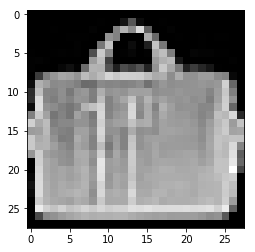

In [5]:
# Draw random image from batch
rnd = np.random.randint(0, batch_size-1)  
img = images[rnd].squeeze().numpy() 
plt.imshow(img, cmap="gray");

## Network architecture

In [6]:
# Number of categories
num_classes = 10

# Instantiate CNN() class
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=7*7*64, out_features=512)
        self.drop1 = nn.Dropout(0.25)   
        self.fc2 = nn.Linear(512, 128)
        self.drop2 = nn.Dropout(0.25)   
        self.fc3 = nn.Linear(128, num_classes)
        
    # Forward pass
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)   # flatten the two-dimensional tensor
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.log_softmax(self.fc3(x), dim=1)   # LogSoftmax for NLLLoss criterion 
        return x
    
model = CNN(num_classes)

## Training the Network

### Train network on GPU if cuda-GPU is available

In [7]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Send model to device
model.to(device);

Device: cuda


### Training hyperparameters

In [8]:
num_epochs = 3
learning_rate = 0.003
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print out training progress every {print_every} batches
print_every = 100 

### Actual training

In [9]:
# Code for printouts and visualizations ----------------

start_time = time.time()

print("Start of training -- Device: {} -- Epochs: {} -- Batches: {} -- Batch size: {}"
      .format(device, num_epochs, len(trainloader), batch_size))

# Initiate variables and lists for training progress printouts and visualizations
running_loss = 0
running_total = 0
running_correct = 0
loss_list = [] 
loss_list_print_every = [] 


# Code for actual training -----------------------------

# Set model to training mode
model.train()

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):       
        
        # Send data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward and backward pass
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

# Code for printouts and visualizations ----------------
        
        # Store running loss, total, correct
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()       

        loss_list.append(loss.item())
        
        # Print out  average training loss and accuracy every {print_every} batches
        if (i+1) % print_every == 0:         
            print("Epoch: {}/{} -- Batches: {}/{} -- Training loss: {:.3f} -- Training accuracy: {:.3f}"
                  .format(epoch+1, num_epochs, i+1, len(trainloader), 
                          running_loss/print_every, running_correct/running_total))
            
            # Store running loss in list
            loss_list_print_every.append(running_loss/print_every)
            
            # Reset running loss and accuracy
            running_loss = 0
            running_total = 0
            running_correct = 0
            
print("Training complete. Total training time: {:.1f} seconds".format(time.time() - start_time))

Start of training -- Device: cuda -- Epochs: 3 -- Batches: 600 -- Batch size: 100
Epoch: 1/3 -- Batches: 100/600 -- Training loss: 0.855 -- Training accuracy: 0.677
Epoch: 1/3 -- Batches: 200/600 -- Training loss: 0.501 -- Training accuracy: 0.815
Epoch: 1/3 -- Batches: 300/600 -- Training loss: 0.423 -- Training accuracy: 0.847
Epoch: 1/3 -- Batches: 400/600 -- Training loss: 0.383 -- Training accuracy: 0.863
Epoch: 1/3 -- Batches: 500/600 -- Training loss: 0.371 -- Training accuracy: 0.867
Epoch: 1/3 -- Batches: 600/600 -- Training loss: 0.356 -- Training accuracy: 0.870
Epoch: 2/3 -- Batches: 100/600 -- Training loss: 0.323 -- Training accuracy: 0.885
Epoch: 2/3 -- Batches: 200/600 -- Training loss: 0.314 -- Training accuracy: 0.884
Epoch: 2/3 -- Batches: 300/600 -- Training loss: 0.321 -- Training accuracy: 0.887
Epoch: 2/3 -- Batches: 400/600 -- Training loss: 0.315 -- Training accuracy: 0.888
Epoch: 2/3 -- Batches: 500/600 -- Training loss: 0.321 -- Training accuracy: 0.890
Epoch

### Training progress visualization

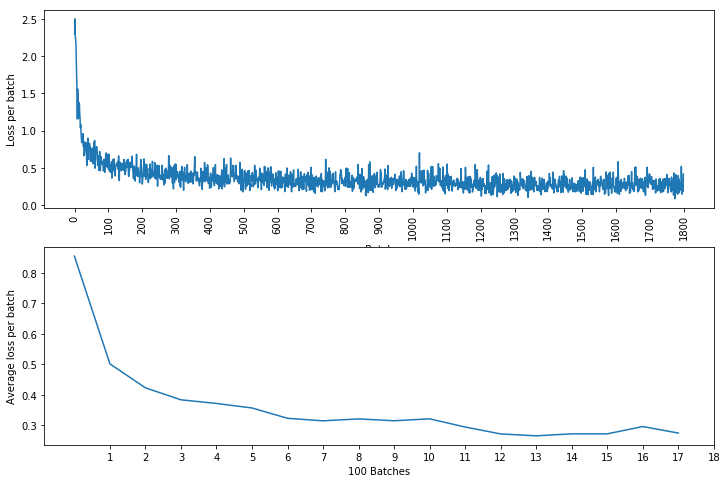

In [10]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
xticks = np.arange(0, len(loss_list)+100, 100)
plt.plot(loss_list)
plt.xticks(xticks)
plt.xticks(rotation=90)
plt.xlabel("Batch")
plt.ylabel("Loss per batch")

plt.subplot(2,1,2)
xticks = np.arange(1, len(loss_list_print_every)+1, 1)
plt.plot(loss_list_print_every)
plt.xticks(xticks)
plt.xlabel(str(print_every)+" Batches")
plt.ylabel("Average loss per batch")

plt.show()

## Model evaluation

### Run images through trained network

In [11]:
# Initialize variables and arrays to store loss and true and predicted labels
running_loss = 0
labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Set model to evaluation mode
model.eval()

with torch.no_grad():   # Deactive gradient calculations   
    for i, (images, labels) in enumerate(testloader):       
        images, labels = images.to(device), labels.to(device)
    
        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        # Store loss and true and predicted labels
        running_loss += loss.item()     
        _, predicted = torch.max(output.data, 1)      
        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

test_accuracy = np.equal(labels_pred, labels_true).mean()         
        
print("Evaluating network on {} images in test set -- Test loss: {:.3f} -- Test accuracy: {:.3f}"
      .format(len(testloader.dataset), running_loss/len(testloader), test_accuracy))

Evaluating network on 10000 images in test set -- Test loss: 0.283 -- Test accuracy: 0.898


### Confusion matrix

In [12]:
cm = np.zeros((num_classes, num_classes))

# Build confusion matrix
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1

# Normalize values
for i in range(num_classes):
    cm[i] = cm[i] / cm[i].sum() 
    
print("Normalized confusion matrix:\n", cm)

Normalized confusion matrix:
 [[0.803 0.001 0.037 0.029 0.003 0.002 0.11  0.    0.015 0.   ]
 [0.001 0.982 0.    0.014 0.002 0.    0.    0.    0.001 0.   ]
 [0.009 0.001 0.854 0.011 0.055 0.    0.07  0.    0.    0.   ]
 [0.008 0.01  0.01  0.918 0.031 0.    0.019 0.    0.004 0.   ]
 [0.    0.    0.07  0.028 0.821 0.    0.079 0.    0.002 0.   ]
 [0.    0.    0.    0.    0.    0.966 0.    0.016 0.002 0.016]
 [0.088 0.    0.067 0.036 0.073 0.    0.724 0.    0.012 0.   ]
 [0.    0.    0.    0.    0.    0.011 0.    0.949 0.    0.04 ]
 [0.001 0.001 0.002 0.005 0.004 0.001 0.    0.002 0.984 0.   ]
 [0.    0.    0.    0.    0.    0.002 0.001 0.016 0.    0.981]]


In [13]:
# Accuracy by category
product_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

print("Accuracy by category:\n", dict(zip(product_list, cm.diagonal())))

Accuracy by category:
 {'T-shirt/top': 0.803, 'Trouser': 0.982, 'Pullover': 0.854, 'Dress': 0.918, 'Coat': 0.821, 'Sandal': 0.966, 'Shirt': 0.724, 'Sneaker': 0.949, 'Bag': 0.984, 'Ankle Boot': 0.981}


### Visualize confusion matrix

The mapping of labels to products is from the [readme](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#labels) in the Fashion-MNISt repository.

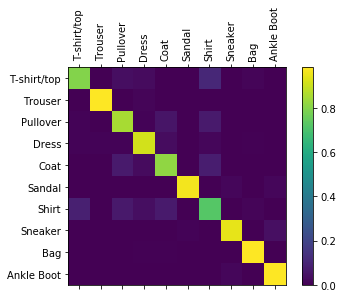

In [14]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + product_list, rotation=90)
ax.set_yticklabels([''] + product_list)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Saving and loading a network

In [15]:
#Save the state dictionary
filename = "CNN_FashionMNIST_checkpoint.pth"
torch.save(model.state_dict(), filename)

In [16]:
# Instantiate model - the architecture needs to be identical with the trained model
loaded_model = CNN(num_classes)

# Load statedict into model
loaded_model.load_state_dict(torch.load(filename))

print(loaded_model)
model = loaded_model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (drop1): Dropout(p=0.25)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (drop2): Dropout(p=0.25)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## Predictor function

In [17]:
def predict(model):
    '''This function draws a random image from a batch of the test data, passes the image through the 
    trained model, and visualizes its class probabilities.'''

    # Load a batch from the test set
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # Draw an image and probability vector from the batch
    rnd = np.random.randint(0, batch_size-1)  
    img = images[rnd]   # image is stored as 1x28x28 tensor

    # convert tensor to size 1x1x28x28 (= batch of size 1)
    img_tensor = img.unsqueeze(0)

    # Send model to CPU for inference and set model to evaluation mode
    model = model.to("cpu")
    model.eval()   

    # Pass the image through the model
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.exp(output)   # Take exponential of output to get non-logarithmized probabilies

    probability_list = output.tolist()[0]   # class probabilities for the image

    # Map labels to product names
    product_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
    
    # Convert image to 2D-array 
    img = img.numpy().squeeze()
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img, cmap="gray")
    ax1.axis("off")
    ax2.barh(range(num_classes), probability_list)
    ax2.set_aspect(0.1)
    ax2.set_yticks(range(num_classes))
    ax2.set_yticklabels(product_list, size = "small");
    ax2.set_title("Class Probabilities")
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

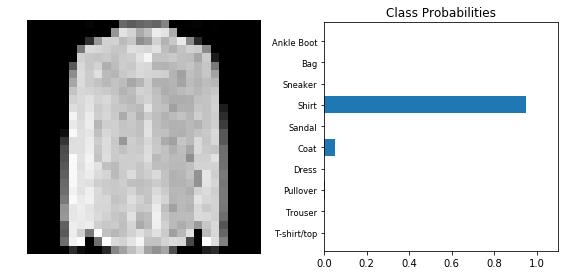

In [21]:
predict(model)